In [30]:
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input, Embedding, Activation
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # data visualization
import matplotlib.dates as mdates
import warnings
from dateutil.relativedelta import relativedelta
from module import myFunctions
import seaborn as sns
import os.path
import statsmodels.api as sm
import importlib
from pandas.plotting import autocorrelation_plot
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
from itertools import cycle
import math
from pylab import rcParams
from matplotlib import rc
%matplotlib inline

def reloadMyModule():
    importlib.reload(myFunctions)


warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

showGraphs = False

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
# https://towardsdatascience.com/cryptocurrency-price-prediction-using-lstms-tensorflow-for-hackers-part-iii-264fcdbccd3f

In [2]:
# Any results you write to the current directory are saved as output.

path_to_file = "./data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv"

if not (os.path.exists(path_to_file)):
    raise Exception("File not found. Please download the file from the link below and place it in the data folder https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data")

coinbase = pd.read_csv(path_to_file)

coinbase.describe()
coinbase.tail()
coinbase.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


Filtrar intervalo de dados


In [3]:
filtered = myFunctions.filterByInterval(coinbase, relativedelta(months=12))

if myFunctions.hasMissingData(filtered['Timestamp'].values):
    raise Exception("Missing data in the dataframe")

print("O intervalo entre datas é de {} até {}, somando um total de {} registros.".format(
    myFunctions.getFirstTimestamp(filtered), myFunctions.getLastTimestamp(filtered), filtered.shape[0]))


O intervalo entre datas é de 30/03/2020 21:01:00 até 30/03/2021 21:00:00, somando um total de 525600 registros.


# Análise e Exploração dos Dados


## Prepara os dados históricos agrupandos por hora


In [4]:
historical_per_day = myFunctions.groupByDay(filtered)
historical_per_hour = myFunctions.groupByHour(filtered)
historical_per_minute = myFunctions.groupByMinute(filtered)

if showGraphs:
    kw = dict(annot_yaxis=10000, annot_xaxis=-1000, annot_xaxis_pos=-6000, annot_yaxis_pos=-
              8000, angle="angle,angleA=0,angleB=90", angle_pos="angle,angleA=0,angleB=-90", showAnnotate=True)
    myFunctions.figureCloses(filtered, 'Close', **kw)


## Gráfico Volatility


In [5]:
def volatiltyGraph(data):
    returns = data.pct_change().dropna(axis=0)
    plt.figure(figsize=(14, 6))
    plt.title('BTC - Volatilidade')
    plt.grid()
    returns['Close'].plot(label='Close', color='blue',
                          linewidth=2, alpha=0.8, legend=True)
    plt.autoscale(tight=True)
    plt.axhline(y=0, color='black')
    plt.axhline(y=0.05, color='red')
    plt.axhline(y=-0.05, color='red')
    plt.axhline(y=0.1, color='red')
    plt.axhline(y=-0.1, color='red')
    plt.xlabel(None)

    plt.show()


if showGraphs:
    volatiltyGraph(historical_per_day)


## Heatmap


In [6]:
def heatmapGraph(data):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(data.corr(), annot=True,
                linewidths=.9, fmt='.1f', ax=ax)
    plt.show()


if showGraphs:
    heatmapGraph(historical_per_day)


## Dia da semana com valor mais baixo


In [7]:
def lowestDuringWeek(data):
    data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    data = data.dropna()

    week = {0: 'Seg', 1: 'Ter', 2: 'Qua',
            3: 'Qui', 4: 'Sex', 5: 'Sab', 6: 'Dom'}
    data['Dia da Semana'] = data['Timestamp'].dt.dayofweek.map(week)

    # count min value for each week day
    idx = data.groupby([pd.Grouper(key='Timestamp', freq='W-MON')]
                       )['Close'].transform(min) == data['Close']

    # data is still in minutes, so I calculate it for days.
    lows_count = data[idx].groupby(
        [pd.Grouper(key='Timestamp', freq='D')]).first().reset_index()
    lows_count = lows_count.dropna()

    sns.set(rc={'figure.figsize': (14, 6)})
    ax = sns.countplot(x='Dia da Semana', data=lows_count, order=[
                       'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'])
    ax.set(ylabel='Quantidade de vezes com valor mais baixo')


if showGraphs:
    lowestDuringWeek(historical_per_minute)


# PREPARAÇÃO DOS DADOS PARA OS MODELOS DE APRENDIZADO DE MÁQUINA


In [15]:
reloadMyModule()
# https://www.kaggle.com/code/jeongbinpark/lstm-can-we-predict-the-bitcoin-price


def removeUnusedColumns(df):
    df.drop(['Open', 'Volume_(BTC)', 'Volume_(Currency)',
            'Weighted_Price', 'High', 'Low'], axis=1, inplace=True)
    return df


def groupByTimer(df, interval):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df = df.set_index('Timestamp')
    df = df.resample(interval).mean()
    df = df.dropna()
    return df


def normalize(scaler, values):
    return scaler.fit_transform(np.array(values).reshape(-1, 1))


df = removeUnusedColumns(filtered.copy())
df = groupByTimer(df, '1H')
scaler = MinMaxScaler()

df['Close'] = normalize(scaler, df['Close'])
scaled_close = df['Close']
scaled_close.shape

(8757,)

In [29]:
def reshape(dataset):
    return dataset.reshape(dataset.shape[0],dataset.shape[1] , 1)


def create_dataset(dataset, loop_back=1):
    """
    Estrutura os dados da maneira correta para o treinamento da rede
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - loop_back):
        dataX.append(dataset[i:(i + loop_back)])
        dataY.append(dataset[i + loop_back])
    return np.array(dataX), np.array(dataY)


def separateTrainTest(dataset, projection_Hours):
    """ 
    Separa o dataset em treino e teste.
    Para isso, o dataset é dividido em duas partes:
    1. A primeira parte é usada para treino.
    2. A segunda parte é usada para teste.
    """
    df_train = dataset[:len(dataset)-projection_Hours].values
    df_test = dataset[len(dataset)-projection_Hours:].values
    print("{0:0.2f}% separado para teste".format((len(df_test)*100)/len(dataset)))
    return df_train, df_test


dias = 15
hours = 24
PROJECTION_HOURS = 48

df_train, df_test = separateTrainTest(scaled_close, dias * hours)
trainX, trainY = create_dataset(df_train, PROJECTION_HOURS)
testX, testY = create_dataset(df_test, PROJECTION_HOURS)

trainX, testX = reshape(trainX), reshape(testX)

print("X_train: ", trainX.shape)
print("X_test: ", testX.shape)


4.11% separado para teste
X_train:  (8349, 48, 1)
X_test:  (312, 48, 1)


In [33]:
DROPOUT = 0.2
WINDOW_SIZE = PROJECTION_HOURS

model = Sequential()
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, trainX.shape[-1])))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))

In [1]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(trainX, trainY, epochs = 2, batch_size =50, validation_split=0.1)


NameError: name 'model' is not defined

In [ ]:
model.evaluate(testX, testY)

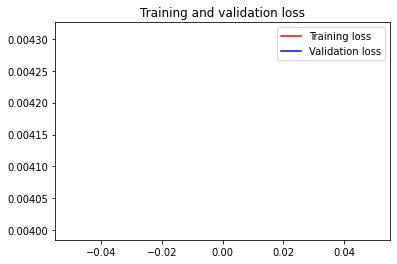

<Figure size 432x288 with 0 Axes>

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [73]:
y_hat = model.predict(testX)

y_test_inverse = scaler.inverse_transform(testY)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

ValueError: in user code:

    File "/home/willian/github/bitcoin_prediction/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/home/willian/github/bitcoin_prediction/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/willian/github/bitcoin_prediction/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/home/willian/github/bitcoin_prediction/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/home/willian/github/bitcoin_prediction/venv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/willian/github/bitcoin_prediction/venv/lib/python3.10/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_12" (type Sequential).
    
    Input 0 of layer "lstm_14" is incompatible with the layer: expected shape=(None, None, 5), found shape=(None, 48, 1)
    
    Call arguments received by layer "sequential_12" (type Sequential):
      • inputs=tf.Tensor(shape=(None, 48, 1), dtype=float32)
      • training=False
      • mask=None


# We will predict 300 datas


In [ ]:
time_step = projection_Hours
x_input=df_test[len(df_test)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
lst_output=[]
n_steps=time_step
i=0
pred_days = 60
while(i<pred_days):
    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

temp_mat = np.empty(pred_days+1)
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]
next_predicted_days_value = temp_mat
next_predicted_days_value = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
new_pred_plot = pd.DataFrame({
    'Predicted Close':next_predicted_days_value
})
names = cycle(['Predicted next 60 days close price'])
fig = px.line(new_pred_plot,x=new_pred_plot.index, y= new_pred_plot['Predicted Close'],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Next 60 days Closing price prediction',
                  plot_bgcolor='white',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(trainY.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(testY.reshape(-1,1))

# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data RMSE:  561.5677956517864
Train data MSE:  315358.38911320653
Train data MAE:  365.8156194109976
-------------------------------------------------------------------------------------
Test data RMSE:  3489.576434561141
Test data MSE:  12177143.692644445
Test data MAE:  1717.5234402753454
-------------------------------------------------------------------------------------
Train data R2 score: 0.9983889725909897
Test data R2 score: 0.924246596755361
